# 이용자들의 다음달 이용횟수 예측하기

In [2]:
import pandas as pd
customer = pd.read_csv('data/스포츠센터데이터/customer_join.csv') #어제 전처리한 파일

In [3]:
customer.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47


In [4]:
customer_clustering = customer[['mean', 'median', 'max', 'min', 'membership_period']]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [5]:
# k-means를 활용하여 cluster를 4개 만들고, 만들어진 결과를 cluster라는 이름의 칼럼으로 추가
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# 스케일 변환
scaler = MinMaxScaler()
customer_clustering_std = scaler.fit_transform(customer_clustering)

# 군집
kmeans = KMeans(n_clusters = 4)
kmeans.fit(customer_clustering_std)

# 생성된 클러스터를 데이터 프레임에 넣습니다.
clusters = kmeans.labels_
customer_clustering.loc[:,'cluster'] = clusters

C:\Users\Joo\AppData\Local\Temp\ipykernel_3900\1868488982.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_clustering.loc[:,'cluster'] = clusters


In [6]:
# agg(<새롭게 들어갈 칼럼의 이름> = (<계산하는데 활용할 칼럼>,<연산 방법>))
customer_clustering.groupby('cluster', as_index = False).agg(count = ('mean','count'))

,cluster,count
0,0,1093
1,1,856
2,2,1255
3,3,988


In [7]:
customer_clustering.groupby('cluster', as_index = False).mean()

,cluster,mean,median,max,min,membership_period
0,0,4.627325,4.618024,7.183898,2.106130,38.343092
1,1,8.000136,7.960280,9.974299,6.099299,6.300234
2,2,3.711459,3.468924,6.244622,1.720319,8.079681
3,3,5.863162,5.865891,8.675101,3.104251,21.779352


In [8]:
# pca를 활용해서 2차원으로 데이터를 축소하고 seaborn을 활용해서 시각화 (11시 25분)
from sklearn.decomposition import PCA
pca = PCA(n_components=2) #2차원으로 변환하라는 코딩
pca.fit(customer_clustering_std)

PCA(n_components=2)

In [9]:
pca_df = pd.DataFrame(pca.transform(customer_clustering_std), columns = ['X','Y'])
pca_df.loc[:,'cluster'] = clusters
pca_df.head(1)

,X,Y,cluster
0,-0.472188,-0.403811,0


<AxesSubplot:xlabel='X', ylabel='Y'>

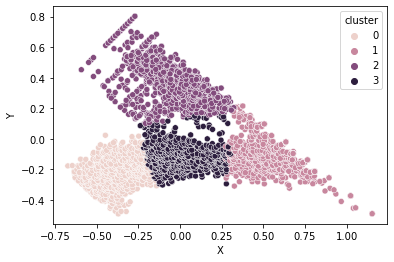

In [10]:
import seaborn as sns
sns.scatterplot(data = pca_df, x = 'X', y = 'Y', hue = 'cluster')

In [11]:
customer_clustering = pd.concat([customer, customer_clustering['cluster']], axis = 1)

In [12]:
customer_clustering.groupby(['cluster','is_deleted' ], as_index = False).agg(count = ('customer_id', 'count'))

,cluster,is_deleted,count
0,0,0,1093
1,1,0,799
2,1,1,57
3,2,0,4
4,2,1,1251
5,3,0,946
6,3,1,42


In [13]:
customer_clustering.groupby(['cluster','routine_flg' ], as_index = False).agg(count = ('customer_id', 'count'))

,cluster,routine_flg,count
0,0,1,1093
1,1,0,80
2,1,1,776
3,2,0,695
4,2,1,560
5,3,0,4
6,3,1,984


# 이 유저가 다음 달에는 몇 번이나 올까?

In [14]:
uselog = pd.read_csv('data/스포츠센터데이터/use_log.csv')
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['연월'] = uselog['usedate'].dt.strftime('%Y%m')
uselog_months = uselog.groupby(['customer_id','연월'], as_index = False).agg(count = ('log_id', 'count'))
uselog_months.head(3)

,customer_id,연월,count
0,AS002855,201804,4
1,AS002855,201805,5
2,AS002855,201806,5


In [15]:
uselog_pivot = pd.pivot_table(data = uselog_months, 
                              index = 'customer_id', 
                              columns = '연월', 
                              values = 'count', 
                              fill_value = 0)

total_column_count = len(uselog_pivot.columns)
set_column_count = 6
result_df = pd.DataFrame()

for i in range(total_column_count-set_column_count):
    selected_df = uselog_pivot.iloc[:,i:i+7]
    selected_df.columns = ['count1','count2','count3','count4','count5','count6','pred']
    result_df = pd.concat([result_df, selected_df])
    
result_df

,count1,count2,count3,count4,count5,count6,pred
customer_id,,,,,,,
AS002855,4,5,5,5,3,7,3
AS008805,0,0,8,7,5,2,2
AS009013,2,0,0,0,0,0,0
AS009373,3,4,4,7,6,6,5
AS015233,0,7,7,5,11,9,7
...,...,...,...,...,...,...,...
TS995853,0,0,0,0,0,11,8
TS998593,9,9,9,7,8,7,8
TS999079,4,6,6,9,6,2,3


In [16]:
predict_data = pd.merge(result_df.reset_index(), customer[['customer_id','membership_period']], on = 'customer_id')
predict_data.head()

,customer_id,count1,count2,count3,count4,count5,count6,pred,membership_period
0,AS002855,4,5,5,5,3,7,3,29
1,AS002855,5,5,5,3,7,3,5,29
2,AS002855,5,5,3,7,3,5,2,29
3,AS002855,5,3,7,3,5,2,6,29
4,AS002855,3,7,3,5,2,6,5,29


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 

X = predict_data.drop(['pred','customer_id'], axis = 1) = predict_data['pred']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3)

model = LinearRegression()
model.fit(X_train,Y_train)

model.score(X_test, Y_test)

0.512309294603071

In [18]:
coef = pd.DataFrame({"feature_names" : model.feature_names_in_, "coefficient": model.coef_})
coef

,feature_names,coefficient
0,count1,-0.039707
1,count2,-0.014833
2,count3,0.025807
3,count4,0.064581
4,count5,0.200343
5,count6,0.518205
6,membership_period,0.008267


In [19]:
print(model.feature_names_in_)

['count1' 'count2' 'count3' 'count4' 'count5' 'count6' 'membership_period']


In [20]:
model.predict([[1, 2, 3, 4, 5, 6, 20],
               [1, 2, 3, 4, 5, 6, 20]])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([5.30636184, 5.30636184])